# Вступление

Этот блокнот является простым базовым введением к такому варианту ансамблевых методов, как стекинг (Stacking). В двух словах, stacking использует в качестве первого уровня (базового) прогнозы нескольких базовых классификаторов, а затем использует другую модель на втором уровне для прогнозирования выходных данных из более ранних прогнозов первого уровня.

Работа со стекингом будет идти на основе датасета Titanic.

## Стекинг. Определение

Стекинг (stacked generalization, stacking) - вариант ансамблевых методов, основанный на идее добавления метапризнаков к исходному набору признаков и обучения метамодели на наборе метапризнаков. Как правило, метапризнаки строятся как результаты предсказаний различных моделей ML. 
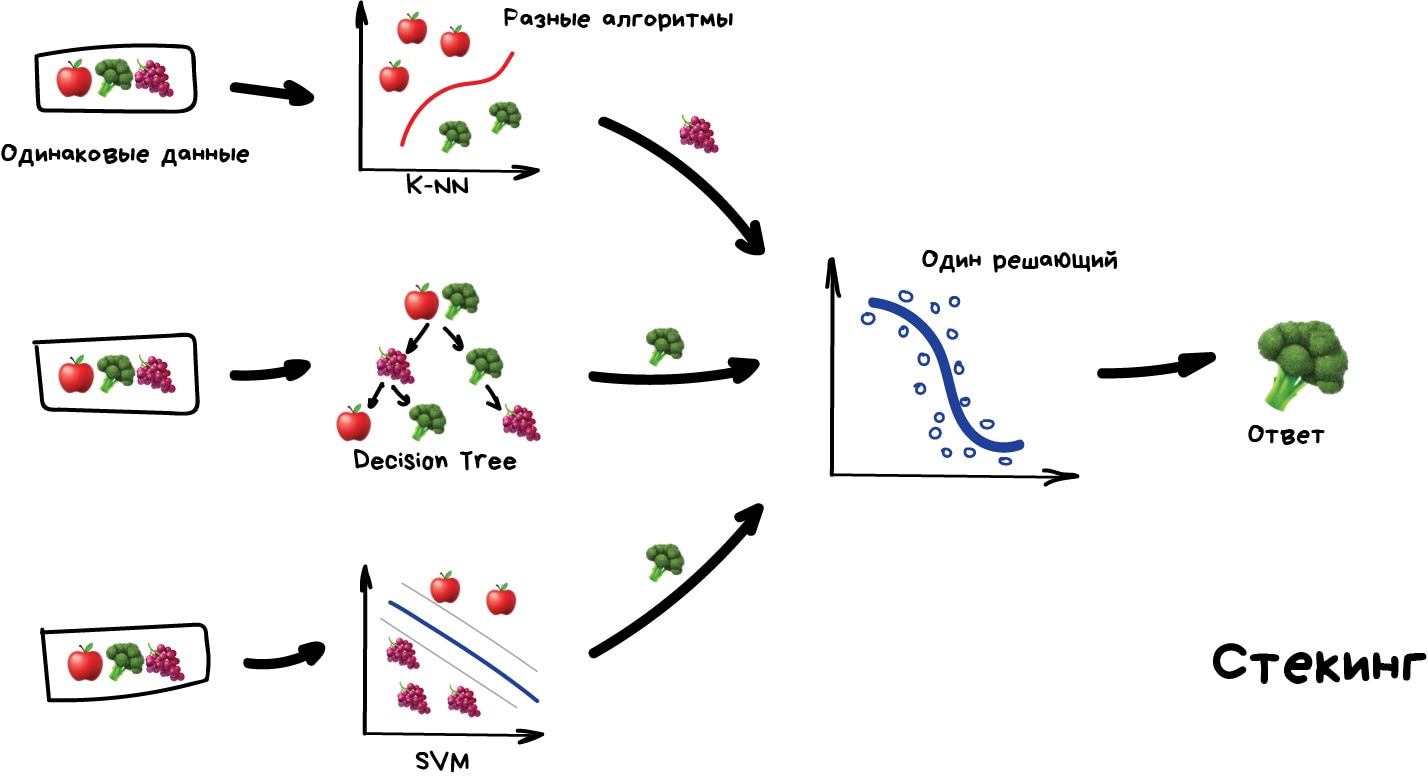
В очень грубой форме стекинг можно описать так:

 - **Шаг 1.** *Строим набор разных моделей на исходном наборе признаков* (например, линейную регрессию, регрессию по knn, регрессию по деревьям, random forest и пару нейросетей впридачу) --- всё, на что способна бурная фантазия ML engineer :)
 - **Шаг 2.** *Каждая из моделей на шаге 1 дала какие-то предсказания,* давайте добавим эти предсказания к исходному набору признаков. Получим так называемые "метапризнаки".
 - **Шаг 3.** *Обучим новую модель ML* (например, опять линейную регрессию) на наборе метапризнаков. Такая модель называется "метамоделью". Результат метамодели будем считать окончательным предсказанием.
 
Описанный вид стекинга самый простой, его часто называют "блендингом" (смешиванием). При желании можно делать многоуровневый стекинг, создавая "метамета...метапризнаки" и "метамета...метамодели" описанным способом. Стоит отметить, что этот приём часто помогает выигрывать различные соревнования по анализу данных на Kaggle, однако не всегда применим в реальных приложениях.


In [1]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Собираемся использовать эти 5 базовых моделей для стекинга
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Исследование атрибутов, проектирование и очистка 

Теперь мы поступим примерно так же, как обычно действуют при решении задач машинного обучения, а именно сначала изучим имеющиеся данные, определим возможные наборы свойств, а также численно закодируем любые категориальные функции.

In [2]:
# Загружаем тренировочные и тестовые данные
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv', sep=',')

# Сохраним ID пассажира для легкого доступа
PassengerId = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print('Тестовая')
test.head(3)

Тестовая


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Дальнейшая задача состоит в том, чтобы каким-то образом извлечь информацию из категориальных переменных 

## Инженерия признаков

In [4]:
full_data = [train, test]

# Некоторые добавленные функции
# Дают длину имени
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Функция, которая сообщает, была ли у пассажира каюта на "Титанике"
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Создайте новый атрибут - размер семьи в виде комбинации SibSp и Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Создайдим новый атрибут "IsAlone" из FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Удалите все пустые значения в столбце "Embarked"
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Удалим все пустые значения в столбце тарифа и создадим новую функцию CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Создадим новый атрибут CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Определим функцию для извлечения дворянских титулов из имен пассажиров
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Если есть титул, извлекаем и возвращаем его.
    if title_search:
        return title_search.group(1)
    return ""
# Создаем новый столбец Титул, содержащий титул пассажира по его имени
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Сгруппируйте все необычные титулы в одну группу "Редкие"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Разметка принадлежности к полу
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Разметка титулов
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Разметка по признаку посадки
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Разметка тарифа
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Разметка возраста
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [5]:
# Выбор атрибутов
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

Итак, теперь, когда мы очистили атрибуты, извлекли соответствующую информацию и удалили столбцы категорий, все наши функции теперь должны быть числовыми - формат, подходящий для использования в наших моделях машинного обучения. Однако, прежде чем мы продолжим, давайте сгенерируем несколько простых графиков корреляции и распределения нашего преобразованного набора данных, чтобы увидеть оценить их характер.

## Визуализация

In [6]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Тепловая карта корреляции Пирсона

Сгенерируем несколько графиков корреляции объектов, чтобы увидеть, насколько один объект связан со следующим. Для этого будем использовать пакет построения графиков Seaborn, который позволяет нам очень удобно строить тепловые карты следующим образом

<Axes: title={'center': 'Корреляция свойств по Пирсону'}>

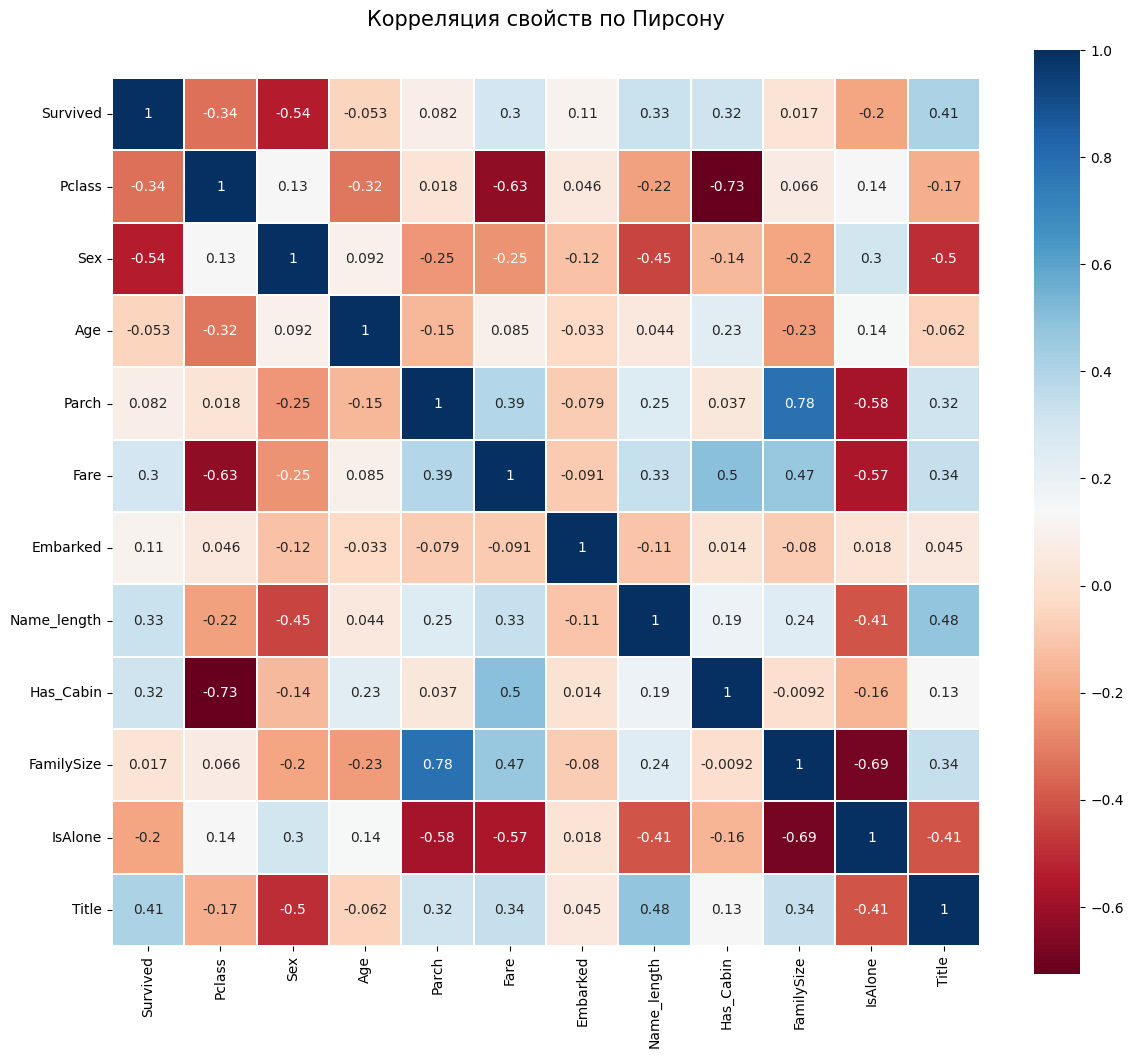

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Корреляция свойств по Пирсону', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Выводы из графика

Единственное, что может сказать нам график корреляции Пирсона, - это то, что существует не так уж много признаков, сильно коррелирующих друг с другом. Это хорошо с точки зрения включения этих функций в вашу модель обучения, потому что это означает, что в нашем обучающем наборе не так много избыточных данных, и мы рады, что каждая функция несет в себе некоторую уникальную информацию. Вот две наиболее коррелирующие характеристики: размер семьи и состав семьи (родители и дети). Я по-прежнему оставлю обе функции включенными для целей этого упражнения.

### Парные диаграммы

Наконец, давайте сгенерируем несколько парных графиков, чтобы наблюдать распределение данных от одного объекта к другому. И снова мы прибегаем к помощи Сиборна.

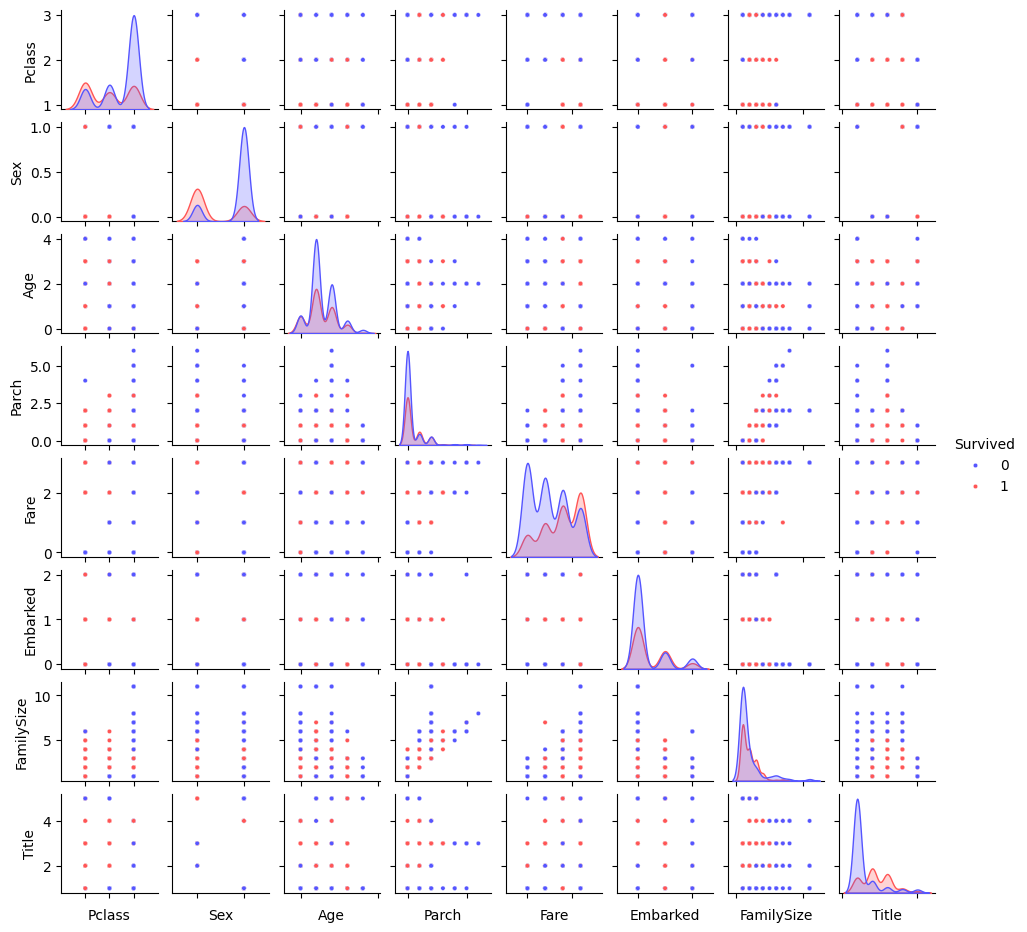

In [8]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ансамбли & Стекинговые модели
Наконец, после этапа разработки свойств и их форматирования, мы, наконец, подходим к сути этого ноутбука.

Создадим стекинговый ансамбль.

### Вспомогательные классы на основе классов Python

Здесь мы прибегаем к использованию классов Python, чтобы сделать код более эффективным.

В приведенном ниже разделе кода описан класс *SklearnHelper*, который позволяет расширять встроенные методы (такие как train, predict и fit), общие для всех классификаторов Sklearn. Следовательно, это исключает избыточность, так как не нужно будет писать одни и те же методы пять раз, если мы захотим вызвать пять разных классификаторов.

In [9]:
# Некоторые полезные параметры, которые пригодятся позже
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # для воспроизводимости
NFOLDS = 5 # установите срезы для прогнозирования по срезам
kf = KFold(n_splits = NFOLDS, random_state=None, shuffle = False)

# Класс для расширения классификатора Sklearn
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
        print(self.clf.fit(x,y).feature_importances_)
    
# Класс для расширения классификатор XGBoost

Посмотрим, что делает приведенный выше код. При создании своих базовых классификаторов будем использовать только модели, уже присутствующие в библиотеке Sklearn, и, следовательно, расширим класс только для этого.

**def init** : стандарт Python для вызова конструктора по умолчанию для класса. Это означает, что когда вы хотите создать объект (классификатор), вы должны задать ему параметры clf (какой классификатор sklearn вы хотите), seed (случайное начальное значение) и params (параметры для классификаторов).

Остальная часть кода - это просто методы класса, которые вызывают соответствующие методы, уже существующие в классификаторах sklearn. По сути, мы создали класс-оболочку для расширения различных классификаторов Sklearn, так что это должно помочь нам сократить необходимость писать один и тот же код снова и снова, когда мы внедряем несколько обучаемых в наш stacker.

### Прогнозы на новых данных

Теперь, как упоминалось выше во вводном разделе, stacking использует предсказания базовых классификаторов в качестве входных данных для обучения модели второго уровня. Однако нельзя просто обучить базовые модели на основе полных обучающих данных, сгенерировать прогнозы на основе полного набора тестов и затем вывести их для обучения второго уровня. Это чревато тем, что прогнозы вашей базовой модели уже "видели" тестовый набор и, следовательно, переобучались при подаче этих прогнозов.

In [10]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Создание базовых моделей первого уровня 

Итак, теперь давайте подготовим пять моделей машинного обучения в качестве классификаторов первого уровня. Все эти модели могут быть удобно вызваны через библиотеку Sklearn и перечислены следующим образом:

 1. Классификатор случайных лесов
 2. Классификатор дополнительных деревьев
 3. Классификатор AdaBoost
 4. Классификатор градиентного бустинга
 5. Машина опорных векторов

### Параметры

Параметры, которые мы перечислим здесь для полноты картины,

**n_jobs** : Количество ядер, используемых для тренировочного процесса. Если установлено значение -1, используются все ядра.

**n_estimators** : Количество деревьев классификации в вашей модели обучения (по умолчанию установлено значение 10)

**max_depth** : Максимальная глубина дерева, или насколько должен быть расширен узел. Будьте осторожны, если установить слишком большое значение, то возникнет риск переобучения, так как дерево будет расти слишком глубоко

**verbose** : Определяет, хотите ли вы выводить какой-либо текст в процессе обучения. Значение 0 подавляет весь текст, в то время как значение 3 выводит процесс изучения дерева на каждой итерации.

 Пожалуйста, ознакомьтесь с полным описанием на официальном веб-сайте Sklearn. Там вы обнаружите, что существует целый ряд других полезных параметров, с которыми вы можете поиграть.

In [11]:
# Введите наши параметры для указанных классификаторов
# Параметры случайного леса
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Параметры расширенных деревьев
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Параметры AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Параметры градиентного бустинга
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Параметры машины опорных векторов
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Кроме того, поскольку мы упомянули об объектах и классах в рамках ООП, давайте теперь создадим 5 объектов, которые представляют наши 5 моделей обучения, с помощью нашего вспомогательного класса Sklearn, который мы определили ранее.

In [12]:
# Создайте 5 объектов, которые представляют наши 4 модели
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Создание массивов NumPy из наших обучающих и тестовых наборов

Подготовив наши базовые модели первого уровня, теперь мы можем подготовить обучающие и тестовые тестовые данные для ввода в наши классификаторы, сгенерировав массивы NumPy из их исходных фреймов данных следующим образом:

In [13]:
# Создадим множество массивов обучающих, тестовых и целевых (сохраненных) фреймов данных для использования в наших моделях
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Создаем массив обучающих данных
x_test = test.values # Создаем массив тестовых данных

### Вывод прогнозов первого уровня

Теперь мы вводим обучающие и тестовые данные в наши 5 базовых классификаторов и используем функцию прогнозирования, которую мы определили ранее, для генерации наших прогнозов первого уровня. 

In [14]:
# Создавадим наши прогнозы тренировок и тестов. Эти базовые результаты будут использоваться в качестве новых атрибутов
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Расширенные деревья
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Случайный лес
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Градиентный бустинг
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Модель опорных векторов

print("Обучение завершено")

Обучение завершено


### Значения признаков, сгенерированные на основе различных классификаторов

Теперь, изучив наши классификаторы первого уровня, мы можем использовать замечательную функцию моделей Sklearn, которая заключается в выводе значений различных функций в обучающих и тестовых наборах с помощью одной очень простой строки кода.

Согласно документации Sklearn, большинство классификаторов встроены с атрибутом, который возвращает значения объектов, просто вводя **.feature_importances_**. Поэтому мы заранее вызовем этот очень полезный атрибут с помощью нашей функции и построим график значимости функций как таковой

In [15]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

In [16]:
print(rf_feature, et_feature, ada_feature, gb_feature)

[0.12721462 0.19831812 0.02921451 0.02133823 0.07199588 0.0237348
 0.11070044 0.06480578 0.06563783 0.01343404 0.27360576] [0.11957734 0.38271747 0.02829439 0.0167959  0.05714442 0.02760086
 0.04699533 0.08298691 0.04325326 0.0215776  0.17305651] [0.028 0.01  0.018 0.066 0.038 0.01  0.696 0.012 0.052 0.002 0.068] [0.08565934 0.01158963 0.0505184  0.01256701 0.05135022 0.0241716
 0.17458467 0.03689738 0.11317834 0.00617388 0.43330953]


Значимость параметров скопируем в списки Python, как показано ниже

In [17]:
rf_features = list(rf_feature)
et_features = list(et_feature)
ada_features = list(ada_feature)
gb_features = list(gb_feature)

Создадим фрейм данных из списков, содержащих данные о важности объектов, для упрощения построения графика с помощью пакета Plotly.

In [18]:
cols = train.columns.values
# Создаем датафрейм с атрибутами
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Интерактивно опишем важность параметров с помощью графических диаграмм рассеяния

На данном этапе я буду использовать интерактивный пакет Plotly, чтобы визуализировать значения важности объектов различных классификаторов с помощью точечной диаграммы, вызвав "Scatter" следующим образом:

In [19]:
# Точечный график
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Теперь давайте вычислим среднее значение важности всех объектов и сохраним его в виде нового столбца во фрейме данных важности объектов.

In [20]:
# Создадим новый столбец, содержащий среднее значение весов свойсты

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

TypeError: can only concatenate str (not "float") to str

### Графическая диаграмма средней важности свойств

Получив среднее значение признака по всем нашим классификаторам, мы можем построить их в виде столбчатой диаграммы следующим образом:

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Прогнозы второго уровня на основе выходных данных первого уровня

#### Вывод первого уровня в виде новых функций

Теперь, получив наши прогнозы первого уровня, можно рассматривать это как, по сути, создание нового набора признаков, которые будут использоваться в качестве обучающих данных для следующего классификатора. Согласно приведенному ниже коду, таким образом, в качестве наших новых столбцов мы используем прогнозы первого уровня из наших предыдущих классификаторов, и мы обучаем следующий классификатор на основе этого.

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

### Тепловая карта корреляции второго уровня на обучающей выборке

In [ ]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

Было довольно много статей и историй победителей конкурса Kaggle о преимуществах наличия обученных моделей, которые в большей степени не коррелируют друг с другом и дают лучшие результаты.

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Теперь, объединив прогнозы обучения первого уровня и тестирования как x_train, так и x_test, мы можем использовать обученную модель второго уровня.

### Модель обучения второго уровня с помощью XGBoost

Здесь мы выбираем чрезвычайно известную библиотеку для расширенной модели обучения дереву, XGBoost. Он был создан для оптимизации крупномасштабных алгоритмов с расширенным деревом. Для получения дополнительной информации об алгоритме ознакомьтесь с [официальной документацией][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

В любом случае, мы вызываем XGBClassifier и обучаем его на обучающих и целевых данных первого уровня и используем изученную модель для прогнозирования тестовых данных следующим образом:

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

Краткий обзор параметров XGBoost, используемых в модели:

**max_depth** : На какую глубину вы хотите вырастить свое дерево. Будьте осторожны, если задано слишком большое значение, это может привести к переобучению.

**gamma** : минимальное уменьшение потерь, необходимое для создания дополнительного разбиения на конечном узле дерева. Чем больше, тем более консервативным будет алгоритм.

**eta** : уменьшение размера шага, используемое на каждом этапе повышения, для предотвращения переобучения

### Подготовка результатов

Наконец, обучив и подогнав все наши модели первого и второго уровней, мы теперь можем вывести прогнозы в надлежащем формате

In [ ]:
# Выводим ответы
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions})

StackingSubmission.head()

### Пути развития
В качестве заключительного замечания следует отметить, что шаги, предпринятые выше, показывают простой способ создания сборщика ансамблей. 
Некоторыми дополнительными шагами, которые могут быть предприняты для улучшения вашего балла, могут быть:

 1. Внедрение хорошей стратегии перекрестной проверки при обучении моделей для нахождения оптимальных значений параметров
 2. Внедрите большее разнообразие базовых моделей для обучения. Чем больше некоррелированных результатов, тем лучше итоговый балл.

In [ ]:
test2 = pd.read_csv('titanic_test_200_1.csv', sep=';')
test2.head()

In [ ]:
test2 = test2.dropna(subset=['Survived'])

In [ ]:
test2.shape

In [ ]:
StackingSubmission_copy = StackingSubmission.iloc[0:214,:]

In [ ]:
StackingSubmission_copy.shape

In [ ]:
StackingSubmission_copy.head()

In [ ]:
test2.head()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy = accuracy_score(test2['Survived'], StackingSubmission_copy['Survived'])
precision = precision_score(test2['Survived'], StackingSubmission_copy['Survived'])
recall = recall_score(test2['Survived'], StackingSubmission_copy['Survived'])
f1 = f1_score(test2['Survived'], StackingSubmission_copy['Survived'])
roc_auc = roc_auc_score(test2['Survived'], StackingSubmission_copy['Survived'])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
# Создание модели нейронной сети
model = Sequential()
model.add(Dense(32, input_shape=(11,), activation = 'relu')) # Первый скрытый слой с 32 нейронами
model.add(Dense(32, activation = 'relu')) # Второй скрытый слой с 32 нейронами
model.add(Dense(1, activation = 'softmax')) # Выходной слой с 10 нейронами (по количеству классов)
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
x_train = train.values
model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=0)
# Оценка точности на тестовой выборке
x_test = test.values
predictions = model.predict(x_test)
StackingSubmission['Survived'] = predictions
#StackingSubmission['PassengerId'] = test['PassengerId'].copy()
#StackingSubmission['PassengerId'] = test['PassengerId'].copy()

#test_loss, test_acc = model.evaluate(x_test, y_test)
#print('Test accuracy:', test_acc)

In [ ]:
x_train.shape

In [ ]:
test2 = pd.read_csv('titanic_test_200_1.csv', sep=';')
StackingSubmission_copy = StackingSubmission.iloc[0:214,:]
accuracy = accuracy_score(test2['Survived'], StackingSubmission_copy['Survived'])
precision = precision_score(test2['Survived'], StackingSubmission_copy['Survived'])
recall = recall_score(test2['Survived'], StackingSubmission_copy['Survived'])
f1 = f1_score(test2['Survived'], StackingSubmission_copy['Survived'])
roc_auc = roc_auc_score(test2['Survived'], StackingSubmission_copy['Survived'])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)